In [2]:
import pandas as pd
import os

In [3]:
save_path = '/home/ark/arya/processed_chunks'
os.makedirs(save_path, exist_ok=True)

In [ ]:
row_count = 0

with gzip.open(file_path, 'rt') as f:
    for _ in f:
        row_count += 1

print(f'Total number of orders: {row_count}')

Total number of orders: 184428061


In [ ]:
# Initialize chunk processing
chunk_size = 10**7  # 10 million rows per chunk
total_rows = 184428061  # Total number of rows in the dataset

# Process the file in chunks
chunk_number = 0
processed_rows = 0

for chunk in pd.read_csv(file_path, chunksize=chunk_size, header=None, compression='gzip'):

    chunk.columns = ['Data']

    # Saving the processed chunk to Google Drive
    chunk_file = os.path.join(save_path, f'chunk_{chunk_number}.csv')
    chunk.to_csv(chunk_file, index=False)
    chunk_number += 1
    processed_rows += len(chunk)
    print(f'Processed rows so far: {processed_rows}')

print("All chunks processed and saved to Google Drive.")

In [4]:
import pandas as pd
import os

# Function to segment each row based on defined lengths
def segment_row(row, lengths):
    positions = [sum(lengths[:i]) for i in range(len(lengths) + 1)]
    return [row[positions[i]:positions[i+1]].strip() for i in range(len(lengths))]

# Path to load processed chunks and to save segmented chunks
load_path = '/home/ark/arya/processed_chunks'
segmented_path = '/home/ark/arya/segmented_chunks'

if not os.path.exists(segmented_path):
    os.makedirs(segmented_path)

# Initializing the column names and segment lengths
columns = ["Record Indicator", "Segment", "Order Number", "Transaction Time",
           "Buy/Sell Indicator", "Activity Type", "Symbol", "Series", "Volume Disclosed",
           "Volume Original", "Limit Price", "Trigger Price", "Market Order Flag",
           "Stop Loss Flag", "IO Flag", "Algo Indicator", "Client Identity Flag"]
segment_lengths = [2, 4, 16, 14, 1, 1, 10, 2, 8, 8, 8, 8, 1, 1, 1, 1, 1]

# Processing and segmenting data in smaller chunks
chunk_size = 1000000  # Number of rows per chunk
for chunk_file in os.listdir(load_path):
    if chunk_file.startswith('chunk_') and chunk_file.endswith('.csv'):
        chunk_path = os.path.join(load_path, chunk_file)
        chunk_iter = pd.read_csv(chunk_path, header=None, chunksize=chunk_size)

        for i, chunk in enumerate(chunk_iter):
            segmented_data = [segment_row(row[0], segment_lengths) for row in chunk.itertuples(index=False)]

            chunk_df = pd.DataFrame(segmented_data, columns=columns)

            chunk_df.to_csv(os.path.join(segmented_path, f"segmented_{chunk_file}_{i}.csv"), index=False)

print("All chunks have been segmented and saved.")


KeyboardInterrupt: 

## Order Imbalance Caluculation and Visualization

orig

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import openpyxl

# Function to convert jiffies to datetime
def jiffies_to_datetime(jiffies):
    base_date = datetime(1980, 1, 1)
    return base_date + timedelta(seconds=jiffies / 65536)

# Function to read and process each chunk
def process_chunk(chunk_file):
    chunk_df = pd.read_csv(chunk_file)

    chunk_df['Transaction Time'] = pd.to_numeric(chunk_df['Transaction Time'], errors='coerce')
    chunk_df = chunk_df.dropna(subset=['Transaction Time'])
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)

    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].apply(jiffies_to_datetime)

    # Converting 'Transaction Time' to datetime and create 5-minute intervals
    chunk_df['Transaction Time'] = pd.to_datetime(chunk_df['Transaction Time'], format='%H:%M:%S')
    chunk_df.set_index('Transaction Time', inplace=True)
    chunk_df['5min Interval'] = chunk_df.index.floor('5T')

    # Filtering for Buy/Sell orders only
    buy_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'B']
    sell_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'S']

    # Aggregating number of orders for each interval
    buy_counts = buy_orders.groupby('5min Interval').size()
    sell_counts = sell_orders.groupby('5min Interval').size()

    # Calculating order imbalance
    imbalance = buy_counts.add(sell_counts, fill_value=0).reset_index()
    imbalance.columns = ['5min Interval', 'Order Imbalance']
    return imbalance

# Initializing an empty DataFrame to store aggregated results
aggregated_imbalance = pd.DataFrame()

# Path to the segmented files
chunked_path = '/media/arya/OS/Users/aryar/Documents/segmented_chunks'

# Processing each chunk
for chunk_file in os.listdir(chunked_path):
    if chunk_file.endswith('.csv'):
        chunk_file_path = os.path.join(chunked_path, chunk_file)
        chunk_imbalance = process_chunk(chunk_file_path)

        if chunk_imbalance.empty:
            continue

        if aggregated_imbalance.empty:
            aggregated_imbalance = chunk_imbalance
        else:
            aggregated_imbalance = aggregated_imbalance.merge(chunk_imbalance, on='5min Interval', how='outer', suffixes=('', '_new'))
            aggregated_imbalance['Order Imbalance'] = aggregated_imbalance['Order Imbalance'].fillna(0) + aggregated_imbalance['Order Imbalance_new'].fillna(0)
            aggregated_imbalance.drop(columns=['Order Imbalance_new'], inplace=True)

# Save the aggregated results to a CSV file
aggregated_imbalance.to_csv('order_imbalance.csv', index=False)


FileNotFoundError: [Errno 2] No such file or directory: '/media/arya/OS/Users/aryar/Documents/segmented_chunks'

new

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import openpyxl

# Function to convert jiffies to datetime
def jiffies_to_datetime(jiffies):
    base_date = datetime(1980, 1, 1)
    return base_date + timedelta(seconds=jiffies / 65536)

# Function to read and process each chunk
def process_chunk(chunk_file):
    chunk_df = pd.read_csv(chunk_file)

    chunk_df['Transaction Time'] = pd.to_numeric(chunk_df['Transaction Time'], errors='coerce')
    chunk_df = chunk_df.dropna(subset=['Transaction Time'])
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)

    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].apply(jiffies_to_datetime)

    # Converting 'Transaction Time' to datetime and create 5-minute intervals
    chunk_df['Transaction Time'] = pd.to_datetime(chunk_df['Transaction Time'], format='%H:%M:%S')
    chunk_df.set_index('Transaction Time', inplace=True)
    chunk_df['5min Interval'] = chunk_df.index.floor('5T')

    # Filtering for Buy/Sell orders only
    buy_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'B']
    sell_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'S']

    # Aggregating number of orders for each interval
    buy_counts = buy_orders.groupby('5min Interval').size()
    sell_counts = sell_orders.groupby('5min Interval').size()

    # Calculating order imbalance
    imbalance = buy_counts.add(sell_counts, fill_value=0).reset_index()
    imbalance.columns = ['5min Interval', 'Order Imbalance']
    return imbalance

# Initializing an empty DataFrame to store aggregated results
aggregated_imbalance = pd.DataFrame()

# Path to the segmented files
chunked_path = '/media/arya/OS/Users/aryar/Documents/segmented_chunks'

# Processing each chunk
for chunk_file in os.listdir(chunked_path):
    if chunk_file.endswith('.csv'):
        chunk_file_path = os.path.join(chunked_path, chunk_file)
        chunk_imbalance = process_chunk(chunk_file_path)

        if chunk_imbalance.empty:
            continue

        if aggregated_imbalance.empty:
            aggregated_imbalance = chunk_imbalance
        else:
            aggregated_imbalance = aggregated_imbalance.merge(chunk_imbalance, on='5min Interval', how='outer', suffixes=('', '_new'))
            aggregated_imbalance['Order Imbalance'] = aggregated_imbalance['Order Imbalance'].fillna(0) + aggregated_imbalance['Order Imbalance_new'].fillna(0)
            aggregated_imbalance.drop(columns=['Order Imbalance_new'], inplace=True)

# Filter for regular trading hours (9:15 AM to 3:30 PM)
start_time = datetime.strptime('09:15', '%H:%M').time()
end_time = datetime.strptime('15:30', '%H:%M').time()

aggregated_imbalance['Time'] = aggregated_imbalance['5min Interval'].dt.time
aggregated_imbalance = aggregated_imbalance[(aggregated_imbalance['Time'] >= start_time) & (aggregated_imbalance['Time'] <= end_time)]
aggregated_imbalance.drop(columns=['Time'], inplace=True)

# Save the aggregated results to a CSV file
aggregated_imbalance.to_csv('order_imbalance.csv', index=False)

# Save coordinates to an Excel file
output_path = 'order_imbalance_2018.xlsx'
aggregated_imbalance.to_excel(output_path, index=False, sheet_name='Coordinates')


FileNotFoundError: [Errno 2] No such file or directory: '/media/arya/OS/Users/aryar/Documents/segmented_chunks'

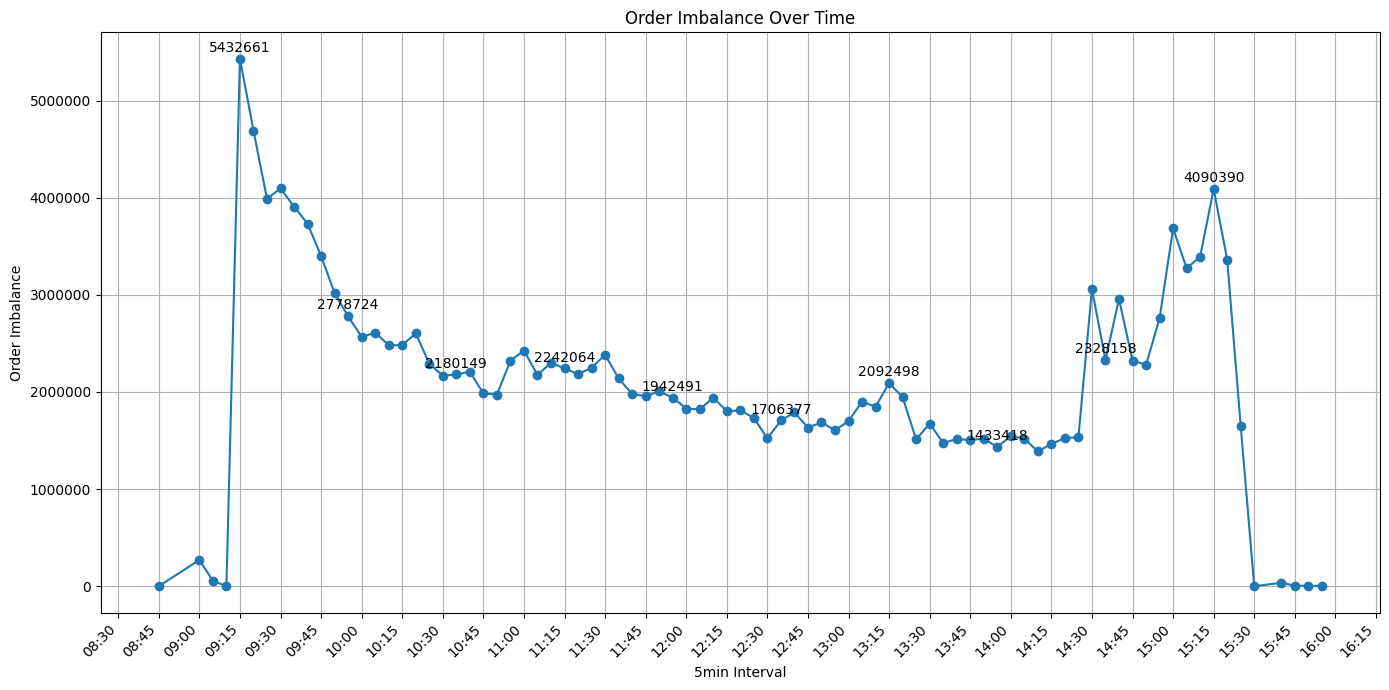

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# Plotting and extracting plot data
order_imbalance_df = pd.read_csv('order_imbalance.csv')

# Convert the '5min Interval' column to datetime format
order_imbalance_df['5min Interval'] = pd.to_datetime(order_imbalance_df['5min Interval'])

# Sorting the DataFrame by '5min Interval'
order_imbalance_df = order_imbalance_df.sort_values(by='5min Interval')

# Resetting the index after sorting
order_imbalance_df = order_imbalance_df.reset_index(drop=True)

# Extracting the coordinates (x: '5min Interval', y: 'Order Imbalance')
x_data = order_imbalance_df['5min Interval']
y_data = order_imbalance_df['Order Imbalance']

# Save coordinates to an Excel file
output_path = 'order_imb_coord_2018.xlsx'
order_imbalance_df.to_excel(output_path, index=False, sheet_name='Coordinates')

# Plotting the order imbalance over time
plt.figure(figsize=(14, 7))
plt.plot(x_data, y_data, marker='o', linestyle='-')

# Formatting y-axis
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# Formatting the x-axis to show 15-minute intervals
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Annotating every 5th point on the graph with its value
for i, (x, y) in enumerate(zip(x_data, y_data)):
    if i % 8 == 4:
        plt.annotate(f"{int(y)}",
                     (x, y),
                     textcoords="offset points",
                     xytext=(0, 5),
                     ha='center')

plt.xlabel('5min Interval')
plt.ylabel('Order Imbalance')
plt.title('Order Imbalance Over Time')
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
order_imbalance_df

,5min Interval,Order Imbalance
0,2018-08-01 08:45:00,2.0
1,2018-08-01 09:00:00,269937.0
2,2018-08-01 09:05:00,55128.0
3,2018-08-01 09:10:00,3.0
4,2018-08-01 09:15:00,5432661.0
...,...,...
79,2018-08-01 15:30:00,1.0
80,2018-08-01 15:40:00,34498.0
81,2018-08-01 15:45:00,5946.0
82,2018-08-01 15:50:00,2839.0


<ipython-input-8-d46983706b37>:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_counts = all_order_counts.groupby('Order Range')['Symbol'].nunique().reset_index()


       Order Range  Number of Stocks
0           0-4999              1446
1        5000-9999               187
2      10000-14999                87
3      15000-19999                46
4      20000-24999                31
5      25000-29999                31
6      30000-34999                12
7      35000-39999                17
8      40000-44999                14
9      45000-49999                20
10     50000-54999                11
11     55000-59999                 9
12     60000-64999                 8
13     65000-69999                 9
14     70000-74999                 4
15     75000-79999                11
16     80000-84999                10
17     85000-89999                10
18     90000-94999                 7
19     95000-99999                 6
20   100000-104999                 3
21   105000-109999                 4
22   110000-114999                 2
23   115000-119999                 6
24   120000-124999                 4
25   125000-129999                 5
2

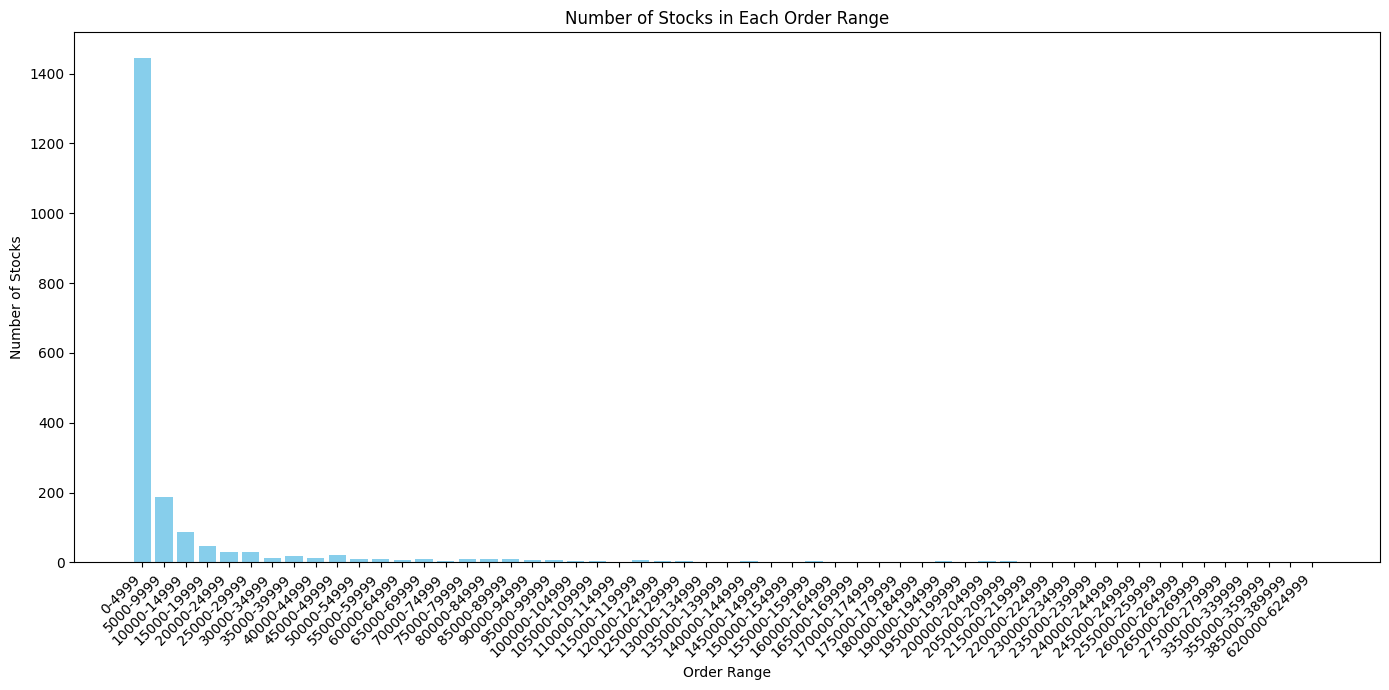

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import gc

# Define the directory containing segmented data
segmented_path = '/media/arya/OS/Users/aryar/Documents/segmented_chunks'

# Function to process each segmented data file and return the order counts
def process_file(file_path):
    data = pd.read_csv(file_path, usecols=['Symbol', 'Order Number'])
    order_counts = data.groupby('Symbol')['Order Number'].nunique().reset_index()
    order_counts.columns = ['Symbol', 'Order Count']
    return order_counts

# Initialize an empty DataFrame to hold the cumulative results
all_order_counts = pd.DataFrame(columns=['Symbol', 'Order Count'])

# Process each file in the segmented directory
for file_name in os.listdir(segmented_path):
    if file_name.startswith('segmented_') and file_name.endswith('.csv'):
        file_path = os.path.join(segmented_path, file_name)
        file_order_counts = process_file(file_path)

        # Merge the results into the cumulative DataFrame
        all_order_counts = pd.concat([all_order_counts, file_order_counts], ignore_index=True)
        all_order_counts = all_order_counts.groupby('Symbol')['Order Count'].sum().reset_index()

        # Clean up memory
        gc.collect()

# Define order range buckets with a larger bin size
max_order_count = all_order_counts['Order Count'].max()
bins = range(0, max_order_count + 5000, 5000)  # Increase bin size to 5000
labels = [f"{i}-{i+4999}" for i in bins[:-1]]

# Categorize stocks based on the order count
all_order_counts['Order Range'] = pd.cut(all_order_counts['Order Count'], bins=bins, labels=labels, right=False)

# Count the number of stocks in each order range
range_counts = all_order_counts.groupby('Order Range')['Symbol'].nunique().reset_index()
range_counts.columns = ['Order Range', 'Number of Stocks']

# Filter out zero values
range_counts = range_counts[range_counts['Number of Stocks'] > 0]

# Display the resulting table
print(range_counts)

# Optional: Save the table to a CSV file
output_path = '/content/drive/My Drive/order_range_table.csv'
range_counts.to_csv(output_path, index=False)

# Plotting the distribution as a bar chart
plt.figure(figsize=(14, 7))
plt.bar(range_counts['Order Range'], range_counts['Number of Stocks'], color='skyblue')
plt.xlabel('Order Range')
plt.ylabel('Number of Stocks')
plt.title('Number of Stocks in Each Order Range')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


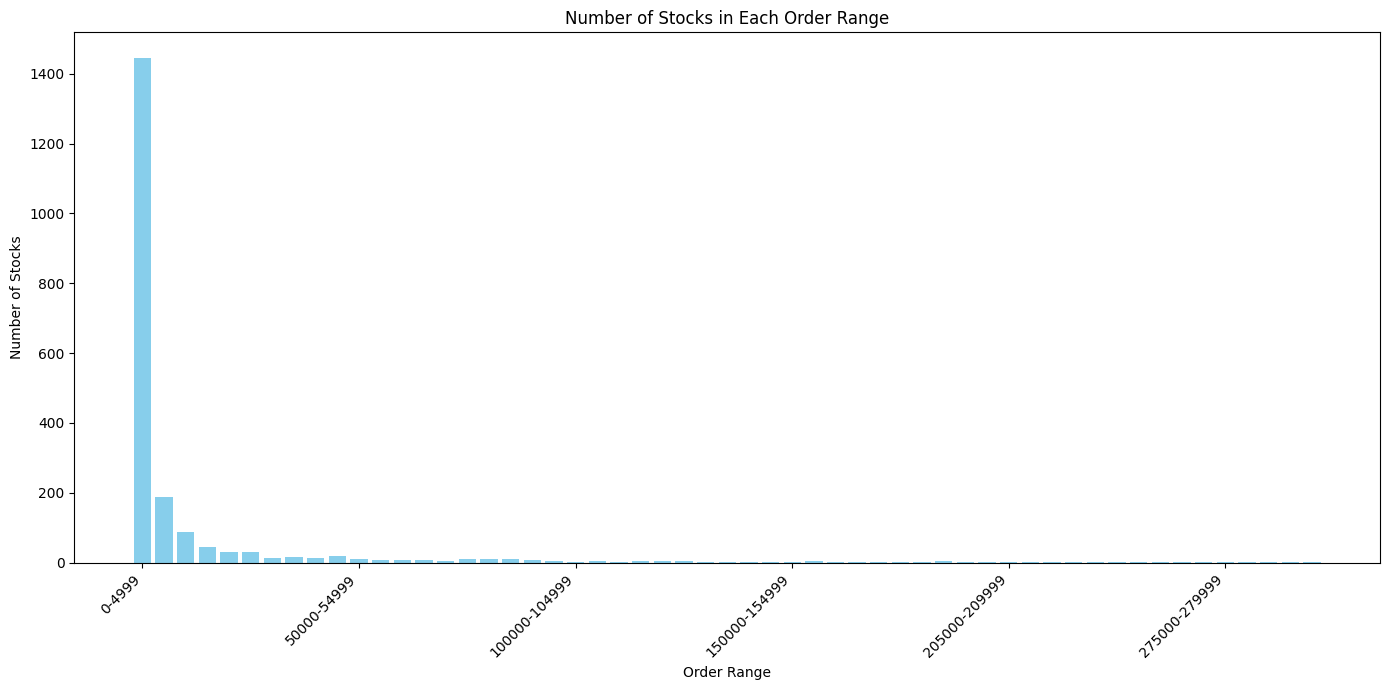

In [ ]:
# Plot with limited x-axis ticks
plt.figure(figsize=(14, 7))
plt.bar(range_counts['Order Range'], range_counts['Number of Stocks'], color='skyblue')
plt.xlabel('Order Range')
plt.ylabel('Number of Stocks')
plt.title('Number of Stocks in Each Order Range')
plt.xticks(rotation=45, ha='right')

# Show every nth label
n = 5  # Show every 10th label
plt.xticks(range(0, len(range_counts['Order Range']), n), range_counts['Order Range'][::n])

plt.tight_layout()
plt.show()


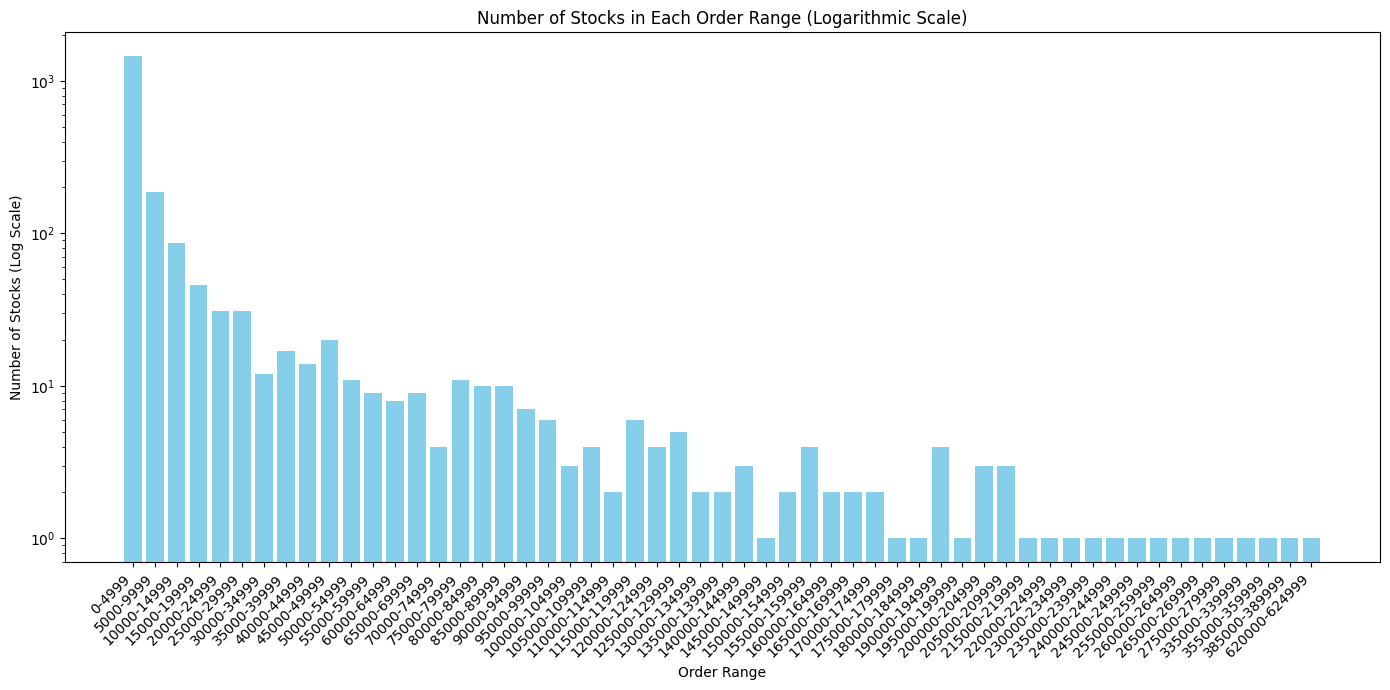

In [ ]:
# Plotting with a logarithmic scale on the y-axis
plt.figure(figsize=(14, 7))
plt.bar(range_counts['Order Range'], range_counts['Number of Stocks'], color='skyblue')
plt.xlabel('Order Range')
plt.ylabel('Number of Stocks (Log Scale)')
plt.title('Number of Stocks in Each Order Range (Logarithmic Scale)')
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.tight_layout()
plt.show()


<ipython-input-12-11de51f7665c>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_counts = range_counts.groupby('Order Range Group')['Number of Stocks'].sum().reset_index()


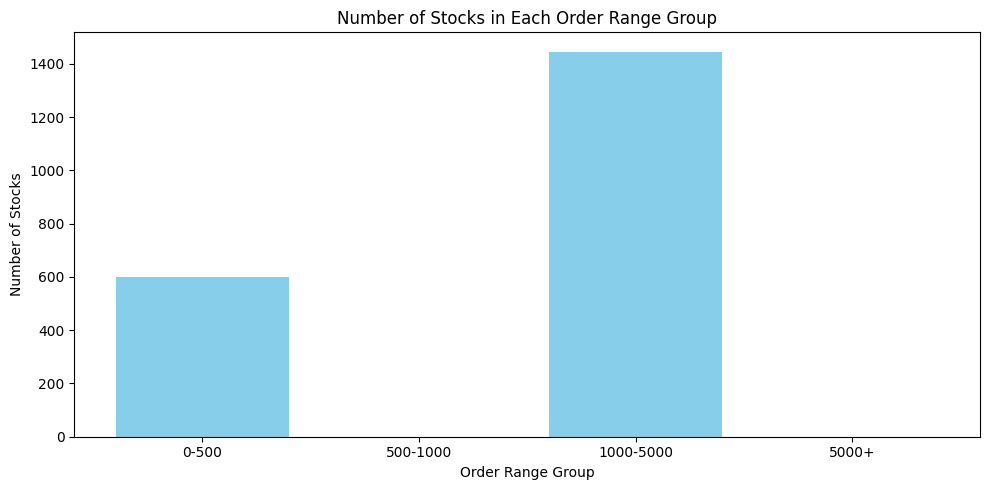

In [ ]:
# Manually group the order ranges into broader categories
range_counts['Order Range Group'] = pd.cut(range_counts['Number of Stocks'], bins=[0, 500, 1000, 5000, 10000],
                                           labels=['0-500', '500-1000', '1000-5000', '5000+'])

# Plotting the grouped ranges
grouped_counts = range_counts.groupby('Order Range Group')['Number of Stocks'].sum().reset_index()

plt.figure(figsize=(10, 5))
plt.bar(grouped_counts['Order Range Group'], grouped_counts['Number of Stocks'], color='skyblue')
plt.xlabel('Order Range Group')
plt.ylabel('Number of Stocks')
plt.title('Number of Stocks in Each Order Range Group')
plt.tight_layout()
plt.show()


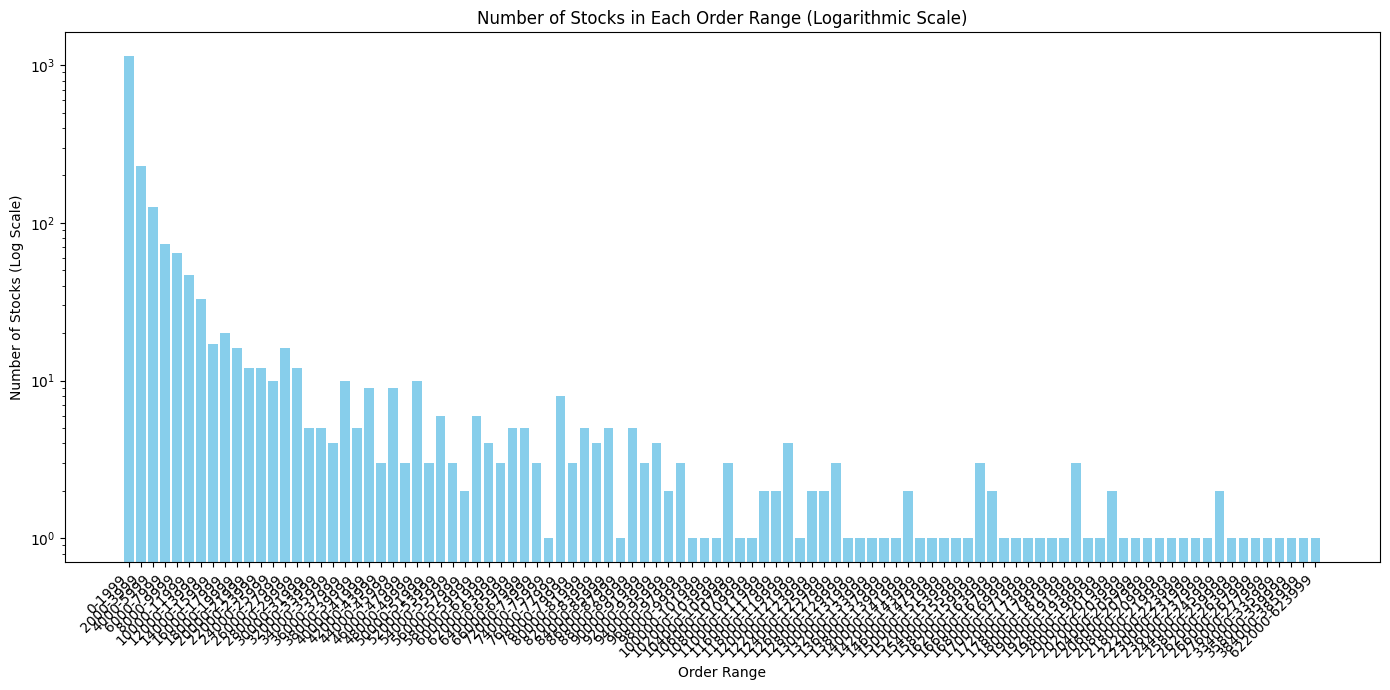

In [ ]:
# Plotting with a logarithmic scale on the y-axis
plt.figure(figsize=(14, 7))
plt.bar(range_counts['Order Range'], range_counts['Number of Stocks'], color='skyblue')
plt.xlabel('Order Range')
plt.ylabel('Number of Stocks (Log Scale)')
plt.title('Number of Stocks in Each Order Range (Logarithmic Scale)')
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.tight_layout()
plt.show()


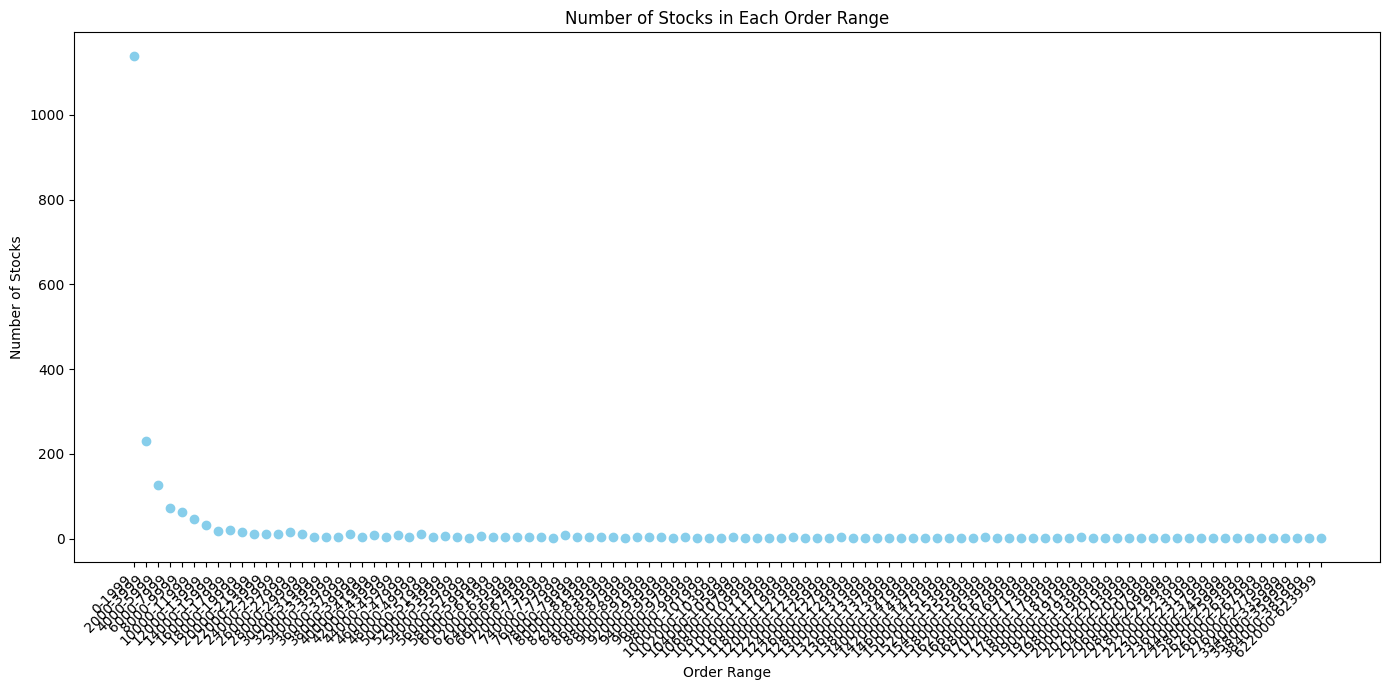

In [ ]:
# Scatter plot to show the number of stocks in each order range
plt.figure(figsize=(14, 7))
plt.scatter(range_counts['Order Range'], range_counts['Number of Stocks'], color='skyblue')
plt.xlabel('Order Range')
plt.ylabel('Number of Stocks')
plt.title('Number of Stocks in Each Order Range')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Order Imbalance Analysis for 3 different types of stocks

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import multiprocessing as mp

# Path to load processed chunks and to save segmented chunks
load_path = '/content/drive/My Drive/processed_chunks'
segmented_path = '/media/arya/OS/Users/aryar/Documents/segmented_chunks'

# Function to convert jiffies to datetime
def jiffies_to_datetime(jiffies):
    base_date = datetime(1980, 1, 1)
    return base_date + timedelta(seconds=jiffies / 65536)

# Function to convert 'Limit Price' from paise to rupees
def convert_price(price_str):
    if price_str == '00000000' or price_str == '0000000.0':  # Non-StopLoss orders
        return 0
    return int(price_str) / 100

# Function to read and process each chunk
def process_chunk(chunk_file_path):
    chunk_df = pd.read_csv(chunk_file_path, dtype=str, low_memory=False)

    # Drop rows with NaN values in 'Limit Price'
    chunk_df = chunk_df.dropna(subset=['Limit Price'])

    # Convert 'Limit Price' from paise to rupees
    chunk_df['Limit Price'] = chunk_df['Limit Price'].apply(convert_price)

    chunk_df['Transaction Time'] = pd.to_numeric(chunk_df['Transaction Time'], errors='coerce')
    chunk_df = chunk_df.dropna(subset=['Transaction Time'])
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].apply(jiffies_to_datetime)

    # Converting 'Transaction Time' to datetime and create 5-minute intervals
    chunk_df['Transaction Time'] = pd.to_datetime(chunk_df['Transaction Time'], format='%H:%M:%S')
    chunk_df.set_index('Transaction Time', inplace=True)
    chunk_df['5min Interval'] = chunk_df.index.floor('5T')

    # Filtering for Buy/Sell orders only
    buy_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'B']
    sell_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'S']

    # Aggregating metrics
    metrics = chunk_df.groupby('5min Interval').agg({
        'Buy/Sell Indicator': 'size',  # Total number of orders
        'Volume Original': 'sum',
        'Limit Price': 'mean'
    }).rename(columns={'Buy/Sell Indicator': 'Order Imbalance'}).reset_index()

    return metrics

penny OI

In [ ]:
def process_all_chunks(chunked_path):
    pool = mp.Pool(mp.cpu_count())
    all_metrics = pool.map(process_chunk, [os.path.join(chunked_path, file) for file in os.listdir(chunked_path) if file.endswith('.csv')])
    pool.close()
    pool.join()

    return pd.concat(all_metrics, ignore_index=True)

# Process all chunks
aggregated_metrics = process_all_chunks(segmented_path)

# Remove outliers based on 'Limit Price'
filtered_df = aggregated_metrics[(aggregated_metrics['Limit Price'] > aggregated_metrics['Limit Price'].quantile(0.05)) &
                                 (aggregated_metrics['Limit Price'] < aggregated_metrics['Limit Price'].quantile(0.95))]

# Classify stocks
stock_price_quantiles = filtered_df['Limit Price'].quantile([0.33, 0.66])

filtered_df['Stock Category'] = pd.cut(filtered_df['Limit Price'],
                                       bins=[-np.inf, stock_price_quantiles[0.33], stock_price_quantiles[0.66], np.inf],
                                       labels=['Penny Stock', 'Mid Price Stock', 'High Price Stock'])

# Aggregating metrics for each category
liquidity_measures = filtered_df.groupby(['Stock Category', '5min Interval']).agg({
    'Order Imbalance': 'sum',
    'Volume Original': 'sum',
    'Limit Price': 'mean'
}).reset_index()

# Save the aggregated results to a CSV file
liquidity_measures.to_csv('liquidity_measures.csv', index=False)


# # Plotting function for each stock category
# def plot_liquidity_measures(category_df, stock_category):
#     fig, ax = plt.subplots(figsize=(14, 7))

#     ax.plot(category_df['5min Interval'], category_df['Order Imbalance'], marker='o', linestyle='-', label='Order Imbalance')
#     ax.set_xlabel('5-Minute Interval')
#     ax.set_ylabel('Order Imbalance')
#     ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
#     ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#     plt.gcf().autofmt_xdate()
#     ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '%1.0f' % x))
#     ax.set_title(f'{stock_category} - Order Imbalance Over Time')
#     ax.legend(loc='upper left')
#     ax.grid(True)

#     plt.tight_layout()
#     plt.show()

# # Generating and displaying plots for each stock category
# for category in ['Penny Stock', 'Mid Price Stock', 'High Price Stock']:
#     category_df = liquidity_measures[liquidity_measures['Stock Category'] == category]
#     plot_liquidity_measures(category_df, category)

## Liquidity Analysis (Based on Order Size)

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Function to convert volume strings to integers
def convert_volume(volume_str):
    return int(volume_str)

# Function to convert jiffies to datetime
def jiffies_to_datetime(jiffies):
    base_date = datetime(1980, 1, 1)
    return base_date + timedelta(seconds=jiffies / 65536)

# Function to convert 'Limit Price' from paise to rupees
def convert_price(price_str):
    if price_str == '00000000' or price_str == '0000000.0':  # Non-StopLoss orders
        return 0
    return int(price_str) / 100

# Function to read and process each chunk
def process_chunk(chunk_file):
    chunk_df = pd.read_csv(chunk_file)

    chunk_df = chunk_df.dropna(subset=['Limit Price'])

    # Convert 'Limit Price' from paise to rupees
    chunk_df['Limit Price'] = chunk_df['Limit Price'].apply(convert_price)

    chunk_df['Transaction Time'] = pd.to_numeric(chunk_df['Transaction Time'], errors='coerce')
    chunk_df = chunk_df.dropna(subset=['Transaction Time'])
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].apply(jiffies_to_datetime)

    # Convert 'Volume Disclosed' and 'Volume Original' from strings to integers
    chunk_df['Volume Disclosed'] = chunk_df['Volume Disclosed'].apply(convert_volume)
    chunk_df['Volume Original'] = chunk_df['Volume Original'].apply(convert_volume)

    # Converting 'Transaction Time' to datetime and create 5-minute intervals
    chunk_df['Transaction Time'] = pd.to_datetime(chunk_df['Transaction Time'], format='%H:%M:%S')
    chunk_df.set_index('Transaction Time', inplace=True)
    chunk_df['5min Interval'] = chunk_df.index.floor('5T')

    # Filtering for Buy/Sell orders only
    buy_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'B']
    sell_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'S']

    # Aggregating number of orders for each interval
    buy_counts = buy_orders.groupby('5min Interval').size()
    sell_counts = sell_orders.groupby('5min Interval').size()

    # Calculating order imbalance
    imbalance = buy_counts.add(sell_counts, fill_value=0).reset_index()
    imbalance.columns = ['5min Interval', 'Order Imbalance']

    # Aggregating other liquidity measures
    volume_original = chunk_df.groupby('5min Interval')['Volume Original'].sum().reset_index()
    total_liquidity = (chunk_df['Volume Original'] * chunk_df['Limit Price']).groupby(chunk_df['5min Interval']).sum().reset_index()
    limit_price_mean = chunk_df.groupby('5min Interval')['Limit Price'].mean().reset_index() # Calculate mean Limit Price for each interval

    # Merge all metrics into one DataFrame
    metrics = imbalance.merge(volume_original, on='5min Interval', how='left')
    metrics = metrics.merge(total_liquidity, on='5min Interval', how='left', suffixes=('', '_TotalLiquidity'))
    metrics = metrics.merge(limit_price_mean, on='5min Interval', how='left') # Merge Limit Price into metrics

    return metrics

/tmp/ipykernel_192372/2301808035.py:45: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  chunk_df['5min Interval'] = chunk_df.index.floor('5T')
/tmp/ipykernel_192372/2301808035.py:45: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  chunk_df['5min Interval'] = chunk_df.index.floor('5T')
/tmp/ipykernel_192372/2301808035.py:45: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  chunk_df['5min Interval'] = chunk_df.index.floor('5T')
/tmp/ipykernel_192372/2301808035.py:45: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  chunk_df['5min Interval'] = chunk_df.index.floor('5T')
/tmp/ipykernel_192372/2301808035.py:45: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  chunk_df['5min Interval'] = chunk_df.index.floor('5T')
/tmp/ipykernel_

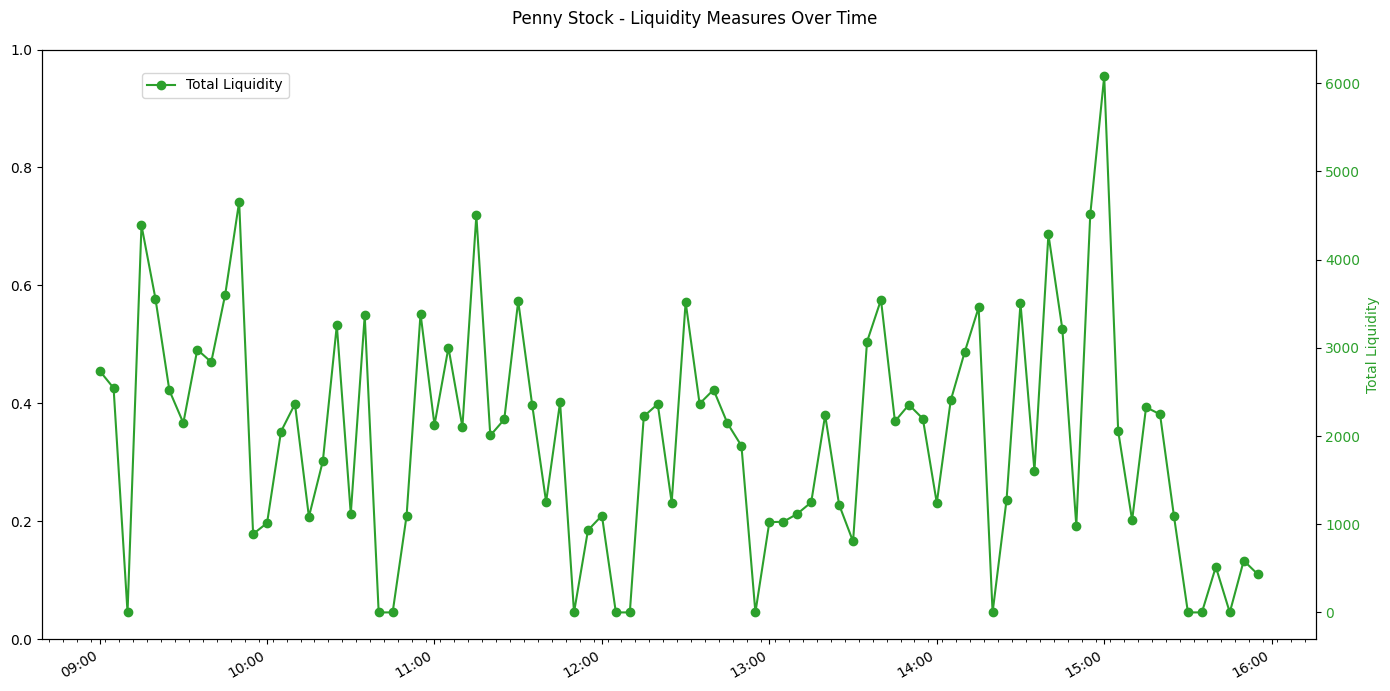

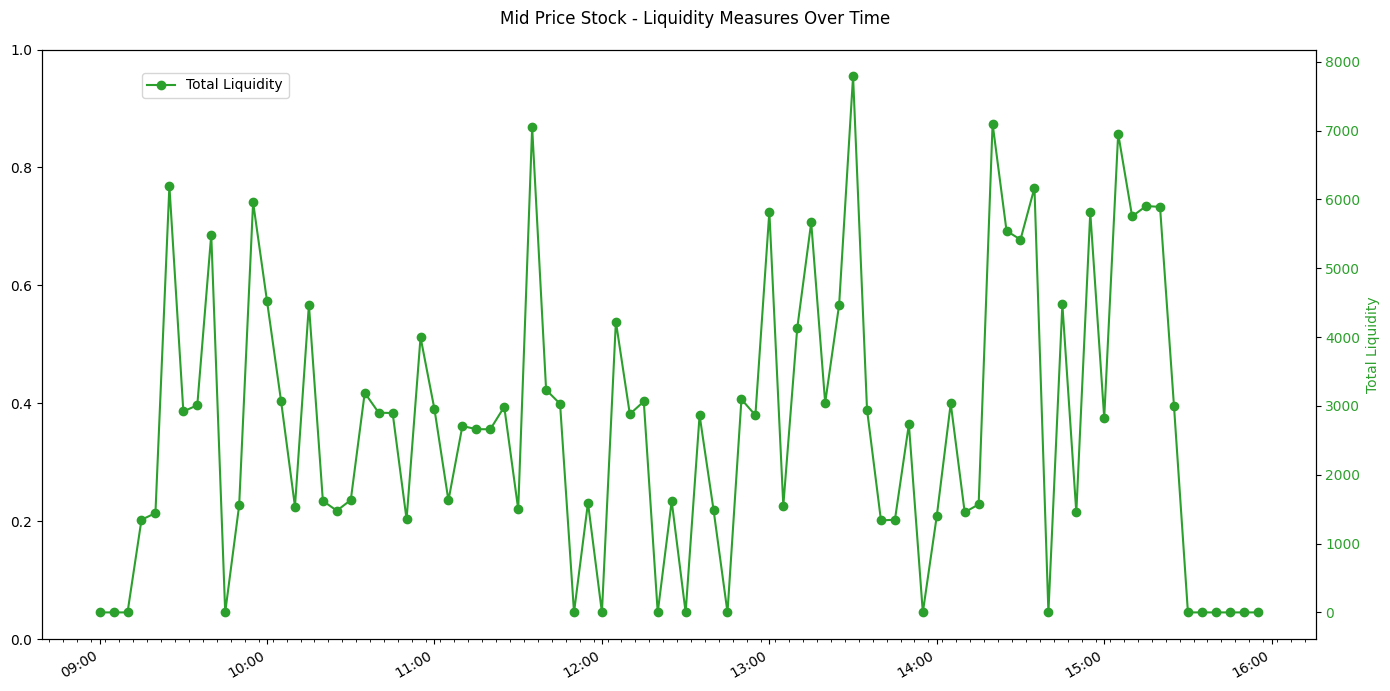

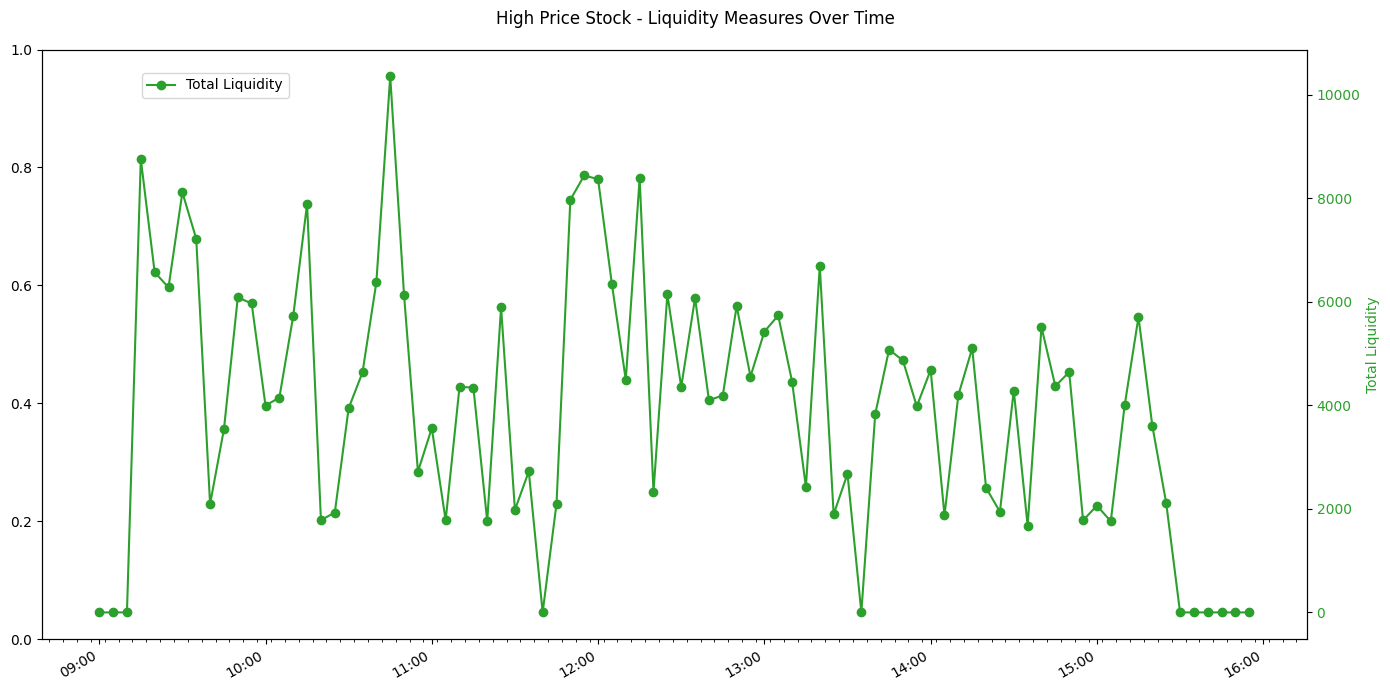

In [5]:
# Initializing an empty DataFrame to store aggregated results
aggregated_metrics = pd.DataFrame()

# Path to the segmented files
chunked_path = '/media/ark/6ed0d405-1106-4ffa-83ca-983b4c9f0bfc/home/ark/arya/segmented_chunks'

# Processing each chunk
for chunk_file in os.listdir(chunked_path):
    if chunk_file.endswith('.csv'):
        chunk_file_path = os.path.join(chunked_path, chunk_file)
        chunk_metrics = process_chunk(chunk_file_path)

        if chunk_metrics.empty:
            continue

        if aggregated_metrics.empty:
            aggregated_metrics = chunk_metrics
        else:
            aggregated_metrics = pd.concat([aggregated_metrics, chunk_metrics])

# Removing outliers based on 'Limit Price'
filtered_df = aggregated_metrics[(aggregated_metrics['Limit Price'] > aggregated_metrics['Limit Price'].quantile(0.05)) &
                                 (aggregated_metrics['Limit Price'] < aggregated_metrics['Limit Price'].quantile(0.95))]

# Classifying the stocks
stock_price_quantiles = filtered_df['Limit Price'].quantile([0.33, 0.66])
filtered_df['Stock Category'] = pd.cut(filtered_df['Limit Price'],
                                       bins=[-np.inf, stock_price_quantiles[0.33], stock_price_quantiles[0.66], np.inf],
                                       labels=['Penny Stock', 'Mid Price Stock', 'High Price Stock'])

# Aggregating metrics for each category
liquidity_measures2 = filtered_df.groupby(['Stock Category', pd.Grouper(key='5min Interval', freq='5T')]).agg({
    'Order Imbalance': 'sum',
    'Volume Original': 'sum',
    'Limit Price': 'sum'  # Change 'Limit Price_TotalLiquidity' to 'Limit Price'
}).reset_index()

# Renaming columns for clarity
liquidity_measures2.rename(columns={
    'Volume Original': 'Total Volume',
    'Limit Price': 'Total Liquidity'
}, inplace=True)

liquidity_measures2.to_csv('liquidity_measures2.csv', index=False)

# Plotting function for each stock category
def plot_liquidity_measures(category_df, stock_category):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax2 = ax1.twinx()
    ax2.plot(category_df['5min Interval'], category_df['Total Liquidity'], marker='o', linestyle='-', label='Total Liquidity', color='tab:green')
    ax2.set_ylabel('Total Liquidity', color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax1.xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gcf().autofmt_xdate()
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '%1.0f' % x))

    fig.suptitle(f'{stock_category} - Liquidity Measures Over Time')
    fig.tight_layout()
    fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

    plt.show()

# Generating and displaying plots for each stock category
for category in ['Penny Stock', 'Mid Price Stock', 'High Price Stock']:
    category_df = liquidity_measures2[liquidity_measures2['Stock Category'] == category]
    plot_liquidity_measures(category_df, category)


In [6]:
aggregated_metrics.head()

,5min Interval,Order Imbalance,Volume Original,0,Limit Price
0,2018-08-01 14:30:00,55993.0,39937242,1.214625e+10,1283.421632
1,2018-08-01 14:35:00,686313.0,450748731,1.432951e+11,975.727579
2,2018-08-01 14:40:00,257694.0,194057369,6.511518e+10,961.413338
0,2018-08-01 13:20:00,1.0,50,1.175750e+04,235.150000
0,2018-08-01 11:25:00,76782.0,31086050,1.917311e+10,2367.331725


#Liquidity (based on Bid-Ask Spread)

<ipython-input-12-ac5a7f817ef8>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)
<ipython-input-12-ac5a7f817ef8>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)
<ipython-input-12-ac5a7f817ef8>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

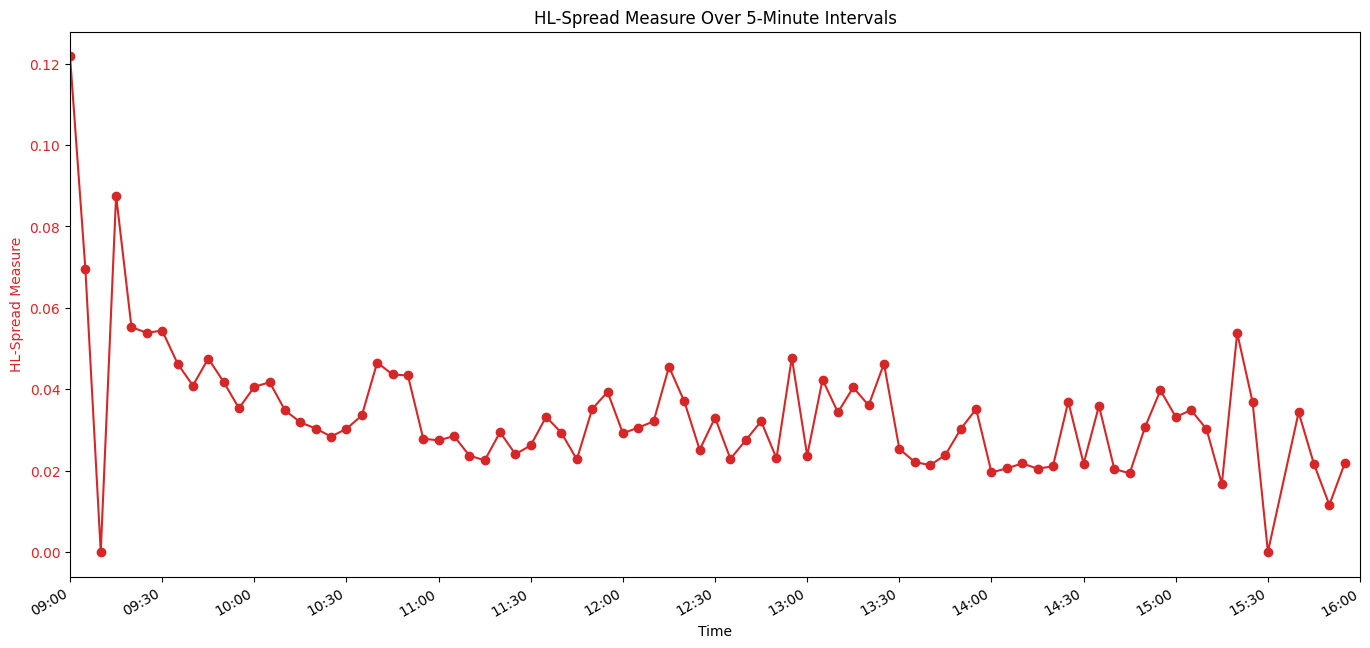

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Function to compute HL-Spread Measure
def calculate_hl_spread(high, low):
    if low == 0:  # Avoid division by zero
        return np.nan
    a = np.log(high / low) / (2 * np.sqrt(2 * np.log(2)))
    hl_spread = (2 * (np.exp(a) - 1)) / (1 + np.exp(a))
    return hl_spread

# Initialize list to store results
all_hl_spread_measures = []

# Process each segmented chunk individually
for chunk_file in os.listdir(segmented_path):
    if chunk_file.startswith('segmented_') and chunk_file.endswith('.csv'):
        chunk_path = os.path.join(segmented_path, chunk_file)
        chunk_df = pd.read_csv(chunk_path)

        chunk_df['Transaction Time'] = pd.to_numeric(chunk_df['Transaction Time'], errors='coerce')
        chunk_df = chunk_df.dropna(subset=['Transaction Time'])
        chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)
        chunk_df['Transaction Time'] = chunk_df['Transaction Time'].apply(jiffies_to_datetime)

        # Drop rows with NaN values in 'Limit Price'
        chunk_df = chunk_df.dropna(subset=['Limit Price'])

        # Convert 'Limit Price' from paise to rupees
        chunk_df['Limit Price'] = chunk_df['Limit Price'].apply(convert_price)

        # Convert Transaction Time to 5-minute intervals
        chunk_df['5min Interval'] = chunk_df['Transaction Time'].dt.floor('5T')

        # Calculate liquidity measures for each 5-minute interval
        interval_data = chunk_df.groupby(['5min Interval', 'Symbol']).agg({
            'Limit Price': ['max', 'min']
        }).reset_index()

        # Rename columns for easier access
        interval_data.columns = ['5min Interval', 'Symbol', 'High', 'Low']

        # Calculate HL-Spread Measure
        interval_data['HL-Spread Measure'] = interval_data.apply(
            lambda row: calculate_hl_spread(row['High'], row['Low']), axis=1)

        # Average the measures for each 5-minute interval
        hl_spread_measures = interval_data.groupby('5min Interval')['HL-Spread Measure'].mean().reset_index()

        # Append to the overall results
        all_hl_spread_measures.append(hl_spread_measures)

# Combine all results into a single DataFrame
hl_spread_measures = pd.concat(all_hl_spread_measures).groupby('5min Interval').mean().reset_index()

# Save the results to a CSV file
hl_spread_measures.to_csv(os.path.join(save_path, 'hl_spread_measures_5min_intervals.csv'), index=False)

# Plot the results
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(hl_spread_measures['5min Interval'], hl_spread_measures['HL-Spread Measure'], color='tab:red', marker='o', linestyle='-', label='HL-Spread Measure')
ax.set_xlabel('Time')
ax.set_ylabel('HL-Spread Measure', color='tab:red')
ax.tick_params(axis='y', labelcolor='tab:red')

# Set x-axis major locator to 5-minute intervals
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Set x-axis range
start_time = hl_spread_measures['5min Interval'].min().replace(hour=9, minute=0)
end_time = hl_spread_measures['5min Interval'].max().replace(hour=16, minute=0)
ax.set_xlim([start_time, end_time])

fig.tight_layout()
fig.autofmt_xdate()
plt.title('HL-Spread Measure Over 5-Minute Intervals')
plt.show()


In [ ]:
os._exit(00)

the 2nd image is Liquidity measure trends over time plot for 01.08.2018 NSE stock data. 1st image is for 11th September, 2012 NSE data. i want you to compare both of them and observe the patterns such as J, U, S or inverted U shape, if they exist, also mention the timestamp at which they exist. finally, give a conclusion on whether the trend of liquidity remains similar or is significantly different

/tmp/ipykernel_195559/2854948212.py:59: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['5min Interval'] = df['Transaction Time'].dt.floor('5T')
/tmp/ipykernel_195559/2854948212.py:59: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['5min Interval'] = df['Transaction Time'].dt.floor('5T')
/tmp/ipykernel_195559/2854948212.py:59: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['5min Interval'] = df['Transaction Time'].dt.floor('5T')
/tmp/ipykernel_195559/2854948212.py:59: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['5min Interval'] = df['Transaction Time'].dt.floor('5T')
/tmp/ipykernel_195559/2854948212.py:59: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['5min Interval'] = df['Transaction Time'].dt.fl

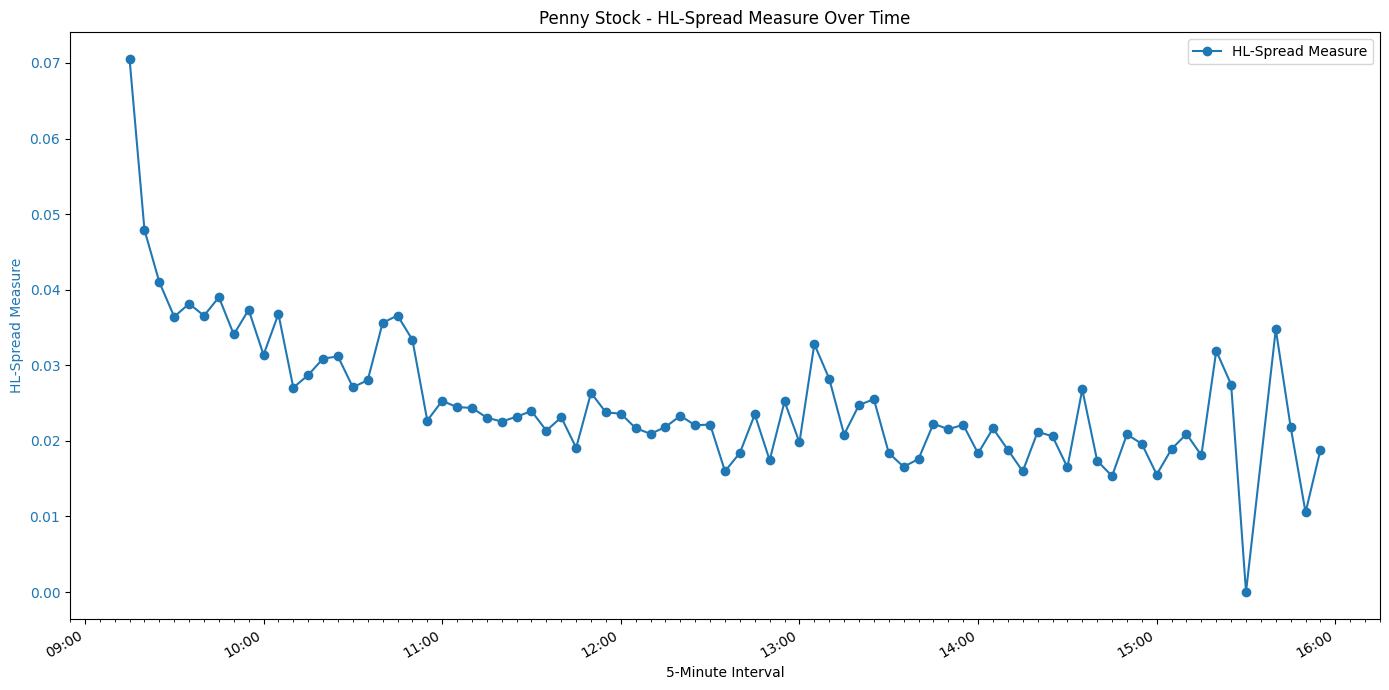

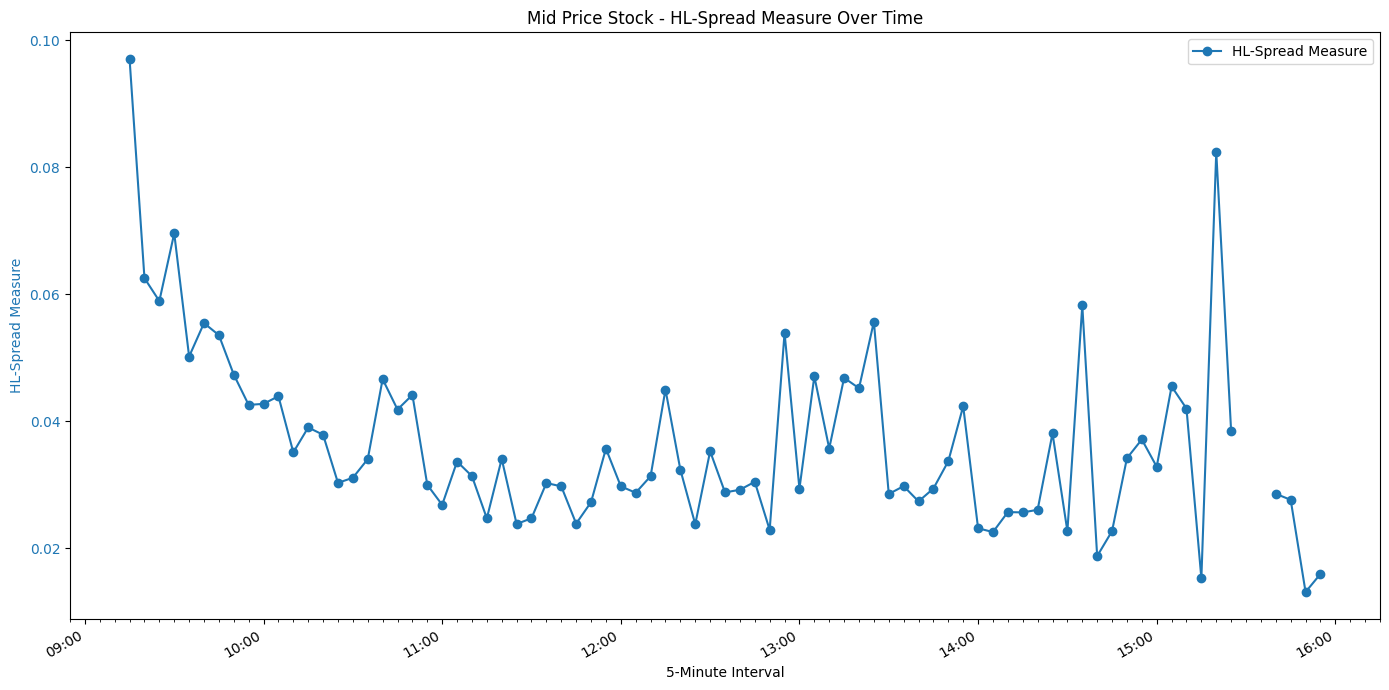

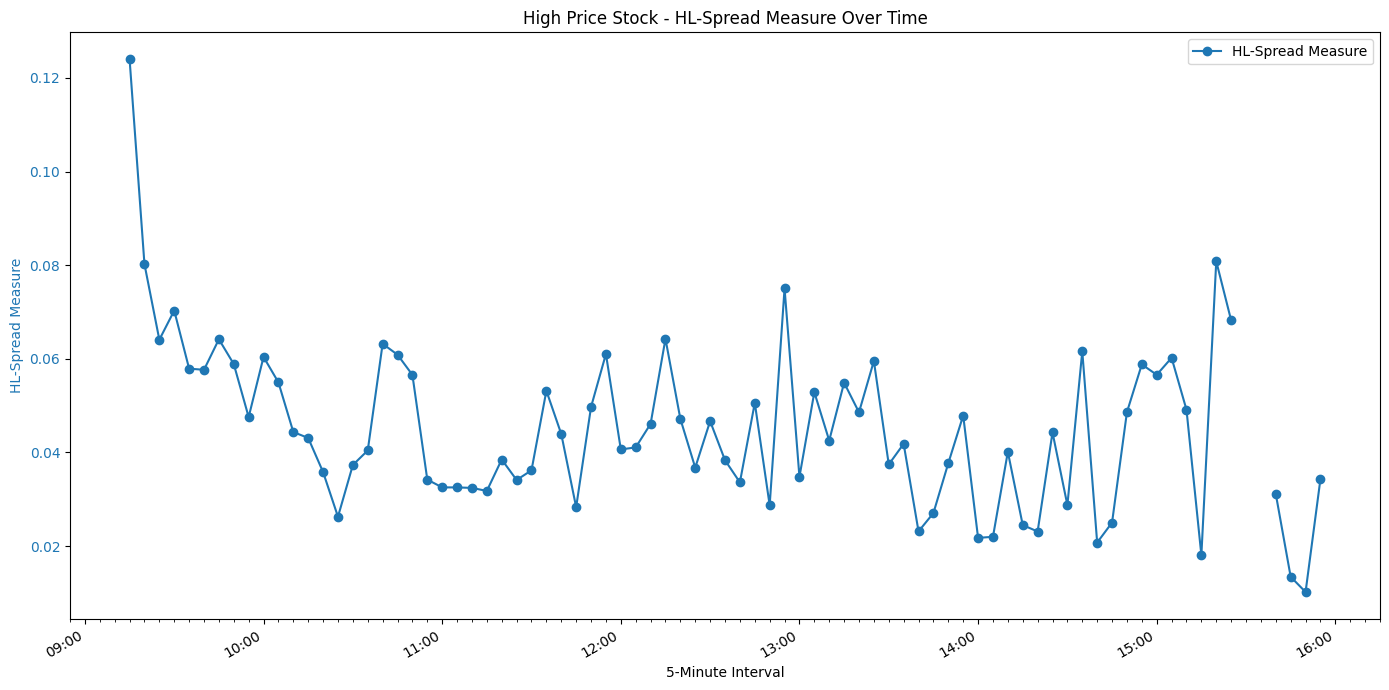

In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Function to convert jiffies to datetime
def jiffies_to_datetime(jiffies):
    base_date = datetime(1980, 1, 1)
    return base_date + timedelta(seconds=jiffies / 65536)

# Function to convert 'Limit Price' from paise to rupees
def convert_price(price_str):
    if price_str == '00000000' or price_str == '0000000.0':  # Non-StopLoss orders
        return 0
    return int(price_str) / 100

# Function to compute HL-Spread Measure
def calculate_hl_spread(high, low):
    if low == 0:  # Avoid division by zero
        return np.nan
    a = np.log(high / low) / (2 * np.sqrt(2 * np.log(2)))
    hl_spread = (2 * (np.exp(a) - 1)) / (1 + np.exp(a))
    return hl_spread

# Initialize DataFrame to store results
all_data = pd.DataFrame()

# Path to the segmented files
segmented_path = '/media/ark/6ed0d405-1106-4ffa-83ca-983b4c9f0bfc/home/ark/arya/segmented_chunks'

# Process each segmented chunk
for chunk_file in os.listdir(segmented_path):
    if chunk_file.startswith('segmented_') and chunk_file.endswith('.csv'):
        chunk_path = os.path.join(segmented_path, chunk_file)
        df = pd.read_csv(chunk_path)

        # Drop rows with NaN values in 'Limit Price'
        df = df.dropna(subset=['Limit Price'])

        # Convert 'Limit Price' from paise to rupees
        df['Limit Price'] = df['Limit Price'].apply(convert_price)

        # Convert 'Transaction Time' to datetime
        df['Transaction Time'] = pd.to_numeric(df['Transaction Time'], errors='coerce')
        df = df.dropna(subset=['Transaction Time'])
        df['Transaction Time'] = df['Transaction Time'].astype(int)
        df['Transaction Time'] = df['Transaction Time'].apply(jiffies_to_datetime)

        # Drop rows with NaN values in 'Limit Price'
        df = df.dropna(subset=['Limit Price'])

        # Convert 'Volume Original' from strings to integers
        df['Volume Original'] = df['Volume Original'].apply(int)

        # Convert 'Transaction Time' to 5-minute intervals
        df['5min Interval'] = df['Transaction Time'].dt.floor('5T')

        # Compute High and Low Prices for each 5-minute interval
        interval_data = df.groupby(['5min Interval', 'Symbol']).agg({
            'Limit Price': ['max', 'min'],
            'Volume Original': 'sum'
        }).reset_index()

        # Rename columns for easier access
        interval_data.columns = ['5min Interval', 'Symbol', 'High', 'Low', 'Volume Original']

        # Calculate HL-Spread Measure
        interval_data['HL-Spread Measure'] = interval_data.apply(lambda row: calculate_hl_spread(row['High'], row['Low']), axis=1)

        # Append to all_data
        all_data = pd.concat([all_data, interval_data])

# Remove outliers based on 'Limit Price'
filtered_df = all_data[(all_data['High'] > all_data['High'].quantile(0.05)) &
                       (all_data['High'] < all_data['High'].quantile(0.95))]

# Classify stocks
stock_price_quantiles = filtered_df['High'].quantile([0.33, 0.66])
filtered_df['Stock Category'] = pd.cut(filtered_df['High'],
                                       bins=[-np.inf, stock_price_quantiles[0.33], stock_price_quantiles[0.66], np.inf],
                                       labels=['Penny Stock', 'Mid Price Stock', 'High Price Stock'])

# Aggregating HL-Spread Measure for each category and interval
liquidity_measures3 = filtered_df.groupby(['Stock Category', '5min Interval']).agg({
    'HL-Spread Measure': 'mean'
}).reset_index()

# Filter out intervals before 9:15
liquidity_measures3 = liquidity_measures3[liquidity_measures3['5min Interval'] >= '2018-08-01 09:15:00']

# Save the aggregated results to a CSV file
save_path = '/media/ark/6ed0d405-1106-4ffa-83ca-983b4c9f0bfc/home/ark/arya/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
liquidity_measures3.to_csv(os.path.join(save_path, 'hl_spread_measures_by_category.csv'), index=False)

# Plotting function for each stock category
def plot_liquidity_measures(category_df, stock_category):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.plot(category_df['5min Interval'], category_df['HL-Spread Measure'], marker='o', linestyle='-', label='HL-Spread Measure', color='tab:blue')
    ax1.set_xlabel('5-Minute Interval')
    ax1.set_ylabel('HL-Spread Measure', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Set x-axis major locator to 5-minute intervals
    ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax1.xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gcf().autofmt_xdate()
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:.2f}'.format(x)))

    plt.title(f'{stock_category} - HL-Spread Measure Over Time')
    plt.tight_layout()
    plt.legend()
    plt.show()

# Generating and displaying plots for each stock category
for category in ['Penny Stock', 'Mid Price Stock', 'High Price Stock']:
    category_df = liquidity_measures3[liquidity_measures3['Stock Category'] == category]
    plot_liquidity_measures(category_df, category)
